# Обучение модели ai-forever/ruRoberta-large для multi-label классификации

In [1]:
!pip install pandas scikit-learn transformers optuna scikit-multilearn openpyxl matplotlib -q 

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_recall_curve, roc_curve, auc, classification_report
from skmultilearn.model_selection import iterative_train_test_split
import joblib
import transformers
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
import json
import math
import gc

# Проверка версий библиотек
print("transformers version:", transformers.__version__)
print("NumPy version:", np.__version__)
print("Optuna version:", optuna.__version__)
print("Matplotlib version:", matplotlib.__version__)  


transformers version: 4.51.3
NumPy version: 1.23.5
Optuna version: 4.3.0
Matplotlib version: 3.10.1


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

In [4]:
# Загрузка датасета
data_path = "../data/processed/final.xlsx"
df = pd.read_excel(data_path)

# Посмотрим на первые строки и общую информацию
print("Размер датасета:", df.shape)
df.head(5)


Размер датасета: (4984, 9)


,Unnamed: 0,full_text,Спорт,Личная жизнь,Юмор,Соцсети,Политика,Реклама,Нет категории
0,614,лебединая песня… (с подтекстом) 2024 год - го...,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,789,ура конкурс!!!!!!! одарим же!!! всех любимых ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,628,"славянский зодиак для познания себе, если еще...",0.0,0.0,0.0,0.5,0.0,0.5,0.0
3,531,английским газетам тяжело даётся ожидание фина...,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,347,"итак, самое главное:) по фактам! по минутам, с...",1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Определяем список тематик (берем из колонок кроме full_text)
all_columns = list(df.columns)
label_cols = [col for col in all_columns if col not in ('full_text', 'Unnamed: 0')]
print("Колонки тем:", label_cols)
num_topics = len(label_cols)
print("Количество тем:", num_topics)


Колонки тем: ['Спорт', 'Личная жизнь', 'Юмор', 'Соцсети', 'Политика', 'Реклама', 'Нет категории']
Количество тем: 7


In [6]:
# Преобразуем вероятности в 0/1 при пороге 0.5
threshold = 0.5
df_labels = (df[label_cols] >= threshold).astype(int)

# Добавим бинарные метки к таблице (для ясности, необязательно)
for col in label_cols:
    df[f"{col}_label"] = df_labels[col]

# Посмотрим фрагмент обновленных данных
df.head(5)


,Unnamed: 0,full_text,Спорт,Личная жизнь,Юмор,Соцсети,Политика,Реклама,Нет категории,Спорт_label,Личная жизнь_label,Юмор_label,Соцсети_label,Политика_label,Реклама_label,Нет категории_label
0,614,лебединая песня… (с подтекстом) 2024 год - го...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0
1,789,ура конкурс!!!!!!! одарим же!!! всех любимых ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0
2,628,"славянский зодиак для познания себе, если еще...",0.0,0.0,0.0,0.5,0.0,0.5,0.0,0,0,0,1,0,1,0
3,531,английским газетам тяжело даётся ожидание фина...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
4,347,"итак, самое главное:) по фактам! по минутам, с...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0


In [7]:
# Количество текстов, содержащих каждую тему (частота меток)
label_counts = df_labels.sum()
print("Число текстов по темам:")
print(label_counts)

# Среднее и распределение числа тем на текст
labels_per_text = df_labels.sum(axis=1)
print("\nРаспределение числа меток на текст:")
print(labels_per_text.value_counts(), "\nСреднее:", labels_per_text.mean())


Число текстов по темам:
Спорт            1590
Личная жизнь      743
Юмор              892
Соцсети          1345
Политика          573
Реклама           571
Нет категории     593
dtype: int64

Распределение числа меток на текст:
1    3611
2    1348
0      25
Name: count, dtype: int64 
Среднее: 1.2654494382022472


In [8]:
# Преобразуем данные для разделения
X = df['full_text'].values.reshape(-1, 1)   
Y = df_labels.values                        

# Выполняем стратифицированное разделение на train/val
test_size = 0.2
X_train, y_train, X_val, y_val = iterative_train_test_split(X, Y, test_size=test_size)

# Преобразуем обратно в списки/таблицы
train_texts = X_train.ravel()   # превращаем (n,1) обратно в (n,)
val_texts = X_val.ravel()
train_labels = y_train
val_labels = y_val

print(f"Обучающая выборка: {len(train_texts)} текстов")
print(f"Валидационная выборка: {len(val_texts)} текстов")


Обучающая выборка: 3987 текстов
Валидационная выборка: 997 текстов


In [9]:
train_label_freq = train_labels.mean(axis=0)
val_label_freq = val_labels.mean(axis=0)
freq_df = pd.DataFrame({'train_frac': train_label_freq, 'val_frac': val_label_freq}, index=label_cols)
print("Доля положительных примеров по темам в выборках:")
print(freq_df)


Доля положительных примеров по темам в выборках:
               train_frac  val_frac
Спорт            0.319037  0.318957
Личная жизнь     0.148984  0.149448
Юмор             0.179082  0.178536
Соцсети          0.269877  0.269809
Политика         0.114873  0.115346
Реклама          0.114623  0.114343
Нет категории    0.118886  0.119358


In [10]:
model_name = "ai-forever/ruRoberta-large"
#model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [11]:
num_labels = num_topics  # количество тем
# Создаем сопоставление индексов и названий тем
id2label = {i: label for i, label in enumerate(label_cols)}
label2id = {label: i for i, label in id2label.items()}

# Загружаем модель для классификации
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)
print("Модель загружена. Число классов:", model.config.num_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель загружена. Число классов: 7


In [12]:
print("torch version:", torch.__version__)
print("CUDA доступна:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Имя устройства:", torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Вычислительное устройство:", device)
!nvidia-smi

torch version: 2.5.1
CUDA доступна: True
Имя устройства: NVIDIA GeForce RTX 3080 Ti
Вычислительное устройство: cuda
Sat Apr 26 22:26:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     Off |   00000000:01:00.0 Off |                  N/A |
|  0%   42C    P2             33W /  400W |    1623MiB /  12288MiB |     29%      Default |
|                       

In [13]:
# Токенизация текстов
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(list(val_texts), padding=True, truncation=True, max_length=128)

# Проверим пример токенизации
print(train_texts[0])
print(train_encodings['input_ids'][0][:20], "...", "длина:", len(train_encodings['input_ids'][0]))


лебединая песня… (с подтекстом)  2024 год - год лебедя по зороастрийскому (некоторые считают его арийским) календарю. тотемный гороскоп от предков человечества нам достался в наследство 32-летний календарь. уникальность тотемного календаря заключается в том, что каждый год в нем имеет своего управителя — священное животное, тотем. тотемный календарь начинает действовать вдень весеннего равноденствия - 20-21-23 марта. зороастрийский новый год носит название навруз (новруз, ноурыз…) (в переводе с персидского «новый день»). если вы родились 5 января 1976 года, то смотрите себя 1975 годом. так как год в этом летоисчислении начинается весной. для информации: «наступающий 2024 год пройдет под управлением грациозного, элегантного лебедя. этот год будет связан с духовным объединением людей. пришло время подняться над материальным миром, воспарить! пора понять, что не хлебом единым жив человек. и еще, верность семье будет самым главным достоинством в глазах тотема. если вы обладаете этим даром 

In [14]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.astype(np.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Некоторые токенизаторы не выдают token_type_ids для моделей типа RoBERTa, поэтому проверим
        if 'token_type_ids' in item and item['token_type_ids'].ndim == 1:
            # Делаем token_type_ids того же измерения, что и input_ids
            item['token_type_ids'] = item['token_type_ids'].unsqueeze(0)
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Создаем объекты Dataset
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

print("Пример батча:")
for i in range(2):
    example = train_dataset[i]
    print(tokenizer.decode(example['input_ids']), "-- метки:", example['labels'].numpy())


Пример батча:
<s>лебединая песня… (с подтекстом)  2024 год - год лебедя по зороастрийскому (некоторые считают его арийским) календарю. тотемный гороскоп от предков человечества нам достался в наследство 32-летний календарь. уникальность тотемного календаря заключается в том, что каждый год в нем имеет своего управителя — священное животное, тотем. тотемный календарь начинает действовать вдень весеннего равноденствия - 20-21-23 марта. зороастрийский новый год носит название навруз (новруз, ноурыз…) (в переводе с</s> -- метки: [0. 0. 0. 0. 0. 1. 0.]
<s>славянский зодиак  для познания себе, если еще мозг не закипел, ознакомьтесь с собой по дням и месяцам славянского зодиака. каждому месяцу в году и дате рождения соответствовало определенное животное. считалось, что люди, рожденные в этом месяце, обладали качествами этого животного. тотемы животных влияли на судьбу человека. таких животных 12, хотя есть предположение, что первоначально их было больше. самый древний славянский животный горо

In [15]:

def objective(trial):
    gc.collect()
    torch.cuda.empty_cache()
    # Выбираем значения гиперпараметров из заданных диапазонов
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    #batch_size = trial.suggest_categorical('batch_size', [4, 8])
    batch_size = trial.suggest_categorical('batch_size', [8, 16])
    num_epochs = trial.suggest_int('num_epochs', 3, 6)
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)
    
    # Инициализируем новую модель с исходными (pretrained) весами для данного trial
    model_trial = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=num_labels, 
        problem_type="multi_label_classification",
        id2label=id2label,
        label2id=label2id
    )
    model_trial.to(device)
    
    # Параметры обучения
    args = TrainingArguments(
        output_dir="optuna_trial",       # временная директория для вывода (можно переиспользовать)
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        metric_for_best_model="f1_micro",
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        # Отключаем сохранения и подробный лог
        save_strategy="no",
        logging_strategy="no",
        # Отключаем прогресс-бар для ускорения вывода
        disable_tqdm=True,
        # Используем GPU и смешанную точность
        dataloader_pin_memory=True,
        fp16=True,
        seed=SEED
    )
    
    # Создаем Trainer
    trainer = Trainer(
        model=model_trial,
        args=args,
        train_dataset=train_dataset,
        # Оценку на валидации проведём вручную после обучения
        # (чтобы сэкономить время, не делаем eval на каждой эпохе)
    )
    
    # Обучаем модель
    trainer.train()
    
    # Предсказываем на валидации
    preds = trainer.predict(val_dataset)
    logits = preds.predictions  # логиты модели (до применения сигмоиды)
    # Применяем сигмоиду к логитам для получения вероятностей
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    # Бинаризуем по порогу 0.5
    y_pred = (probs >= 0.5).astype(int)
    y_true = preds.label_ids
    
    # Вычисляем micro F1 как целевую метрику
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    # Опционально: очищаем GPU память (если большие модели, чтобы не накапливались)
    torch.cuda.empty_cache()
    
    # Возвращаем значение, которое хотим **максимизировать**
    return f1_micro

In [16]:
# Создаем исследование Optuna
study = optuna.create_study(direction='maximize', study_name="Multilabel_Optimization")
# Запускаем поиск 
study.optimize(objective, n_trials=100)

print("Наилучшее значение F1 (micro) на валидации: {:.4f}".format(study.best_value))
print("Лучшие гиперпараметры:", study.best_params)


[I 2025-04-26 22:26:12,077] A new study created in memory with name: Multilabel_Optimization
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.1189, 'train_samples_per_second': 113.837, 'train_steps_per_second': 7.138, 'train_loss': 0.1759001708984375, 'epoch': 5.0}


[I 2025-04-26 22:29:10,658] Trial 0 finished with value: 0.7429963459196103 and parameters: {'learning_rate': 1.2017820673136863e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.022870592669541303}. Best is trial 0 with value: 0.7429963459196103.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.0996, 'train_samples_per_second': 78.763, 'train_steps_per_second': 9.858, 'train_loss': 0.4531757362381012, 'epoch': 5.0}


[I 2025-04-26 22:33:27,598] Trial 1 finished with value: 0.3577339274347549 and parameters: {'learning_rate': 2.520060193280556e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.08269849120512518}. Best is trial 0 with value: 0.7429963459196103.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 176.0233, 'train_samples_per_second': 113.252, 'train_steps_per_second': 7.101, 'train_loss': 0.1867997802734375, 'epoch': 5.0}


[I 2025-04-26 22:36:27,178] Trial 2 finished with value: 0.7552 and parameters: {'learning_rate': 2.5818376644830798e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.07064120623097118}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 304.3508, 'train_samples_per_second': 78.6, 'train_steps_per_second': 9.837, 'train_loss': 0.1433375275127077, 'epoch': 6.0}


[I 2025-04-26 22:41:35,385] Trial 3 finished with value: 0.7499005964214712 and parameters: {'learning_rate': 1.2216594833548418e-05, 'batch_size': 8, 'num_epochs': 6, 'weight_decay': 0.027809320554246952}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 176.5196, 'train_samples_per_second': 112.934, 'train_steps_per_second': 7.081, 'train_loss': 0.155079443359375, 'epoch': 5.0}


[I 2025-04-26 22:44:36,070] Trial 4 finished with value: 0.7471490365709792 and parameters: {'learning_rate': 3.304086346337269e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.03430846353508548}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 176.7308, 'train_samples_per_second': 112.799, 'train_steps_per_second': 7.073, 'train_loss': 0.45901279296875, 'epoch': 5.0}


[I 2025-04-26 22:47:36,311] Trial 5 finished with value: 0.0 and parameters: {'learning_rate': 4.7024030991351144e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.07086771290249363}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.5874, 'train_samples_per_second': 113.06, 'train_steps_per_second': 7.089, 'train_loss': 0.16455879720052083, 'epoch': 6.0}


[I 2025-04-26 22:51:11,396] Trial 6 finished with value: 0.7356042173560422 and parameters: {'learning_rate': 1.0924903486191258e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.037502495425502685}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 105.7673, 'train_samples_per_second': 113.088, 'train_steps_per_second': 7.091, 'train_loss': 0.24043404134114582, 'epoch': 3.0}


[I 2025-04-26 22:53:00,674] Trial 7 finished with value: 0.7254985150615189 and parameters: {'learning_rate': 1.0047035372176014e-05, 'batch_size': 16, 'num_epochs': 3, 'weight_decay': 0.05254140124971828}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 105.7885, 'train_samples_per_second': 113.065, 'train_steps_per_second': 7.09, 'train_loss': 0.461830078125, 'epoch': 3.0}


[I 2025-04-26 22:54:49,971] Trial 8 finished with value: 0.0 and parameters: {'learning_rate': 3.8708793687708895e-05, 'batch_size': 16, 'num_epochs': 3, 'weight_decay': 0.09208881770794522}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 254.0199, 'train_samples_per_second': 78.478, 'train_steps_per_second': 9.822, 'train_loss': 0.1489553203085859, 'epoch': 5.0}


[I 2025-04-26 22:59:07,818] Trial 9 finished with value: 0.7500999600159935 and parameters: {'learning_rate': 2.9405892932387716e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.012106873889132765}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.7435, 'train_samples_per_second': 78.661, 'train_steps_per_second': 9.845, 'train_loss': 0.2962556888679703, 'epoch': 4.0}


[I 2025-04-26 23:02:34,432] Trial 10 finished with value: 0.6845694799658995 and parameters: {'learning_rate': 1.715629904782852e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.06218353354112337}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.7046, 'train_samples_per_second': 78.676, 'train_steps_per_second': 9.847, 'train_loss': 0.1705893017724903, 'epoch': 4.0}


[I 2025-04-26 23:06:00,894] Trial 11 finished with value: 0.7518248175182481 and parameters: {'learning_rate': 2.4828601792423826e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.0733747947493944}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.7385, 'train_samples_per_second': 78.663, 'train_steps_per_second': 9.845, 'train_loss': 0.17146977059587926, 'epoch': 4.0}


[I 2025-04-26 23:09:27,605] Trial 12 finished with value: 0.75 and parameters: {'learning_rate': 1.8967700731965708e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.07492807920345339}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.7323, 'train_samples_per_second': 78.665, 'train_steps_per_second': 9.845, 'train_loss': 0.1727542456739651, 'epoch': 4.0}


[I 2025-04-26 23:12:54,100] Trial 13 finished with value: 0.7465475223395613 and parameters: {'learning_rate': 2.1612394535129528e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.055735417591040906}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 140.7956, 'train_samples_per_second': 113.271, 'train_steps_per_second': 7.102, 'train_loss': 0.20583024597167968, 'epoch': 4.0}


[I 2025-04-26 23:15:18,358] Trial 14 finished with value: 0.7429769392033543 and parameters: {'learning_rate': 1.548834770619055e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.09733056605355467}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 152.1081, 'train_samples_per_second': 78.635, 'train_steps_per_second': 9.842, 'train_loss': 0.19849839653264864, 'epoch': 3.0}


[I 2025-04-26 23:17:54,218] Trial 15 finished with value: 0.7449392712550608 and parameters: {'learning_rate': 2.521792920389577e-05, 'batch_size': 8, 'num_epochs': 3, 'weight_decay': 0.06748207229366264}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 304.3336, 'train_samples_per_second': 78.605, 'train_steps_per_second': 9.838, 'train_loss': 0.13787959015361453, 'epoch': 6.0}


[I 2025-04-26 23:23:02,314] Trial 16 finished with value: 0.7445544554455445 and parameters: {'learning_rate': 3.133245711830171e-05, 'batch_size': 8, 'num_epochs': 6, 'weight_decay': 0.08545370885900008}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 140.7916, 'train_samples_per_second': 113.274, 'train_steps_per_second': 7.103, 'train_loss': 0.18314944458007812, 'epoch': 4.0}


[I 2025-04-26 23:25:27,174] Trial 17 finished with value: 0.7476559315124337 and parameters: {'learning_rate': 2.1538038341629682e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.0427805490032834}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 140.8125, 'train_samples_per_second': 113.257, 'train_steps_per_second': 7.102, 'train_loss': 0.18486441040039062, 'epoch': 4.0}


[I 2025-04-26 23:27:51,688] Trial 18 finished with value: 0.7351874244256348 and parameters: {'learning_rate': 4.067436887954021e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.07994875475957926}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.4911, 'train_samples_per_second': 78.642, 'train_steps_per_second': 9.843, 'train_loss': 0.15273272374827782, 'epoch': 5.0}


[I 2025-04-26 23:32:09,199] Trial 19 finished with value: 0.7456530529720987 and parameters: {'learning_rate': 1.472231576324234e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.06156292781917182}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 304.4397, 'train_samples_per_second': 78.577, 'train_steps_per_second': 9.834, 'train_loss': 0.45886214160091016, 'epoch': 6.0}


[I 2025-04-26 23:37:17,558] Trial 20 finished with value: 0.0 and parameters: {'learning_rate': 2.6613643803870655e-05, 'batch_size': 8, 'num_epochs': 6, 'weight_decay': 0.04833607088415707}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.1427, 'train_samples_per_second': 78.75, 'train_steps_per_second': 9.856, 'train_loss': 0.1541635884072833, 'epoch': 5.0}


[I 2025-04-26 23:41:34,566] Trial 21 finished with value: 0.751993620414673 and parameters: {'learning_rate': 3.0261017503097008e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.00993575253390895}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.1078, 'train_samples_per_second': 78.761, 'train_steps_per_second': 9.857, 'train_loss': 0.17248613437813126, 'epoch': 5.0}


[I 2025-04-26 23:45:51,547] Trial 22 finished with value: 0.7384131971720346 and parameters: {'learning_rate': 3.597420099285068e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.002337764155641491}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 252.9785, 'train_samples_per_second': 78.801, 'train_steps_per_second': 9.862, 'train_loss': 0.4046918544119489, 'epoch': 5.0}


[I 2025-04-26 23:50:08,386] Trial 23 finished with value: 0.35785536159601 and parameters: {'learning_rate': 2.8014485759709776e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.013315036224214018}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.3702, 'train_samples_per_second': 78.806, 'train_steps_per_second': 9.863, 'train_loss': 0.17188527445516033, 'epoch': 4.0}


[I 2025-04-26 23:53:34,890] Trial 24 finished with value: 0.740501212611156 and parameters: {'learning_rate': 2.331381422769637e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.06681055082003384}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.754, 'train_samples_per_second': 78.56, 'train_steps_per_second': 9.832, 'train_loss': 0.14825829637791207, 'epoch': 5.0}


[I 2025-04-26 23:57:52,447] Trial 25 finished with value: 0.7463162086818 and parameters: {'learning_rate': 1.999095929766192e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.09000471092915337}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.1972, 'train_samples_per_second': 113.269, 'train_steps_per_second': 7.102, 'train_loss': 0.1405584004720052, 'epoch': 6.0}


[I 2025-04-27 00:01:27,513] Trial 26 finished with value: 0.7520693732755223 and parameters: {'learning_rate': 3.348771273813485e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.05920229314026023}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.3469, 'train_samples_per_second': 113.188, 'train_steps_per_second': 7.097, 'train_loss': 0.14489840698242187, 'epoch': 6.0}


[I 2025-04-27 00:05:02,349] Trial 27 finished with value: 0.7440944881889764 and parameters: {'learning_rate': 4.829924886413657e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.045857544452974214}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.2669, 'train_samples_per_second': 113.231, 'train_steps_per_second': 7.1, 'train_loss': 0.13435160319010417, 'epoch': 6.0}


[I 2025-04-27 00:08:37,120] Trial 28 finished with value: 0.7505938242280285 and parameters: {'learning_rate': 3.245480464367005e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.05926659219199086}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.1973, 'train_samples_per_second': 113.268, 'train_steps_per_second': 7.102, 'train_loss': 0.14163124593098958, 'epoch': 6.0}


[I 2025-04-27 00:12:11,816] Trial 29 finished with value: 0.7503937007874015 and parameters: {'learning_rate': 4.017860940186855e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.02125732180794907}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.1157, 'train_samples_per_second': 113.312, 'train_steps_per_second': 7.105, 'train_loss': 0.13904835001627605, 'epoch': 6.0}


[I 2025-04-27 00:15:46,445] Trial 30 finished with value: 0.7443875541551792 and parameters: {'learning_rate': 2.9680531805673592e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.02918638120007984}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.82, 'train_samples_per_second': 113.383, 'train_steps_per_second': 7.11, 'train_loss': 0.15545863037109375, 'epoch': 5.0}


[I 2025-04-27 00:18:45,743] Trial 31 finished with value: 0.75 and parameters: {'learning_rate': 3.520153950444624e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.0747128838676375}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.9135, 'train_samples_per_second': 113.323, 'train_steps_per_second': 7.106, 'train_loss': 0.1576712890625, 'epoch': 5.0}


[I 2025-04-27 00:21:45,142] Trial 32 finished with value: 0.7407111466240511 and parameters: {'learning_rate': 2.3343464887495026e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.07648704427580913}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.7432, 'train_samples_per_second': 78.661, 'train_steps_per_second': 9.845, 'train_loss': 0.46051624733842683, 'epoch': 4.0}


[I 2025-04-27 00:25:11,686] Trial 33 finished with value: 0.0 and parameters: {'learning_rate': 2.633201255787897e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.06381893931773434}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.9007, 'train_samples_per_second': 113.331, 'train_steps_per_second': 7.106, 'train_loss': 0.15472947998046874, 'epoch': 5.0}


[I 2025-04-27 00:28:11,096] Trial 34 finished with value: 0.7513015618742491 and parameters: {'learning_rate': 2.4363642401536094e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.05398938863449924}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.3666, 'train_samples_per_second': 78.68, 'train_steps_per_second': 9.847, 'train_loss': 0.41349192525676354, 'epoch': 5.0}


[I 2025-04-27 00:32:28,488] Trial 35 finished with value: 0.0 and parameters: {'learning_rate': 4.2802808578489735e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.08357108039139373}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.1088, 'train_samples_per_second': 113.316, 'train_steps_per_second': 7.105, 'train_loss': 0.13731187947591145, 'epoch': 6.0}


[I 2025-04-27 00:36:03,213] Trial 36 finished with value: 0.7452054794520548 and parameters: {'learning_rate': 3.46367443848543e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.06981494455830722}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.6095, 'train_samples_per_second': 78.605, 'train_steps_per_second': 9.838, 'train_loss': 0.16132660829471443, 'epoch': 5.0}


[I 2025-04-27 00:40:20,631] Trial 37 finished with value: 0.75 and parameters: {'learning_rate': 3.010217966095132e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.03755412357754922}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 105.5419, 'train_samples_per_second': 113.329, 'train_steps_per_second': 7.106, 'train_loss': 0.215987548828125, 'epoch': 3.0}


[I 2025-04-27 00:42:09,804] Trial 38 finished with value: 0.7473162675474814 and parameters: {'learning_rate': 2.738747388858335e-05, 'batch_size': 16, 'num_epochs': 3, 'weight_decay': 0.00014735032581684668}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 140.6652, 'train_samples_per_second': 113.376, 'train_steps_per_second': 7.109, 'train_loss': 0.1933198699951172, 'epoch': 4.0}


[I 2025-04-27 00:44:33,948] Trial 39 finished with value: 0.7445852063751532 and parameters: {'learning_rate': 1.9706863109163216e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.07076085577438364}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.0875, 'train_samples_per_second': 78.767, 'train_steps_per_second': 9.858, 'train_loss': 0.15955627074461423, 'epoch': 5.0}


[I 2025-04-27 00:48:50,821] Trial 40 finished with value: 0.739542225730071 and parameters: {'learning_rate': 3.2613180334338785e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.057323162979838006}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.9301, 'train_samples_per_second': 113.312, 'train_steps_per_second': 7.105, 'train_loss': 0.15161949462890625, 'epoch': 5.0}


[I 2025-04-27 00:51:50,368] Trial 41 finished with value: 0.7415730337078652 and parameters: {'learning_rate': 2.3256612403307355e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.0517530002591433}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.941, 'train_samples_per_second': 113.305, 'train_steps_per_second': 7.105, 'train_loss': 0.155682666015625, 'epoch': 5.0}


[I 2025-04-27 00:54:49,808] Trial 42 finished with value: 0.7453168593064966 and parameters: {'learning_rate': 2.4220577755683585e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.05453037859060315}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.9148, 'train_samples_per_second': 113.322, 'train_steps_per_second': 7.106, 'train_loss': 0.1551416748046875, 'epoch': 5.0}


[I 2025-04-27 00:57:49,259] Trial 43 finished with value: 0.7482993197278912 and parameters: {'learning_rate': 2.5199886710370162e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.04089403365785066}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 140.6709, 'train_samples_per_second': 113.371, 'train_steps_per_second': 7.109, 'train_loss': 0.19771282958984376, 'epoch': 4.0}


[I 2025-04-27 01:00:13,443] Trial 44 finished with value: 0.7482828282828283 and parameters: {'learning_rate': 2.834213794730809e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.07826062294378014}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.8902, 'train_samples_per_second': 113.338, 'train_steps_per_second': 7.107, 'train_loss': 0.16262591552734376, 'epoch': 5.0}


[I 2025-04-27 01:03:12,847] Trial 45 finished with value: 0.7403494514425031 and parameters: {'learning_rate': 1.801630052806417e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.06303959343247138}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.137, 'train_samples_per_second': 113.301, 'train_steps_per_second': 7.104, 'train_loss': 0.13671567789713543, 'epoch': 6.0}


[I 2025-04-27 01:06:47,626] Trial 46 finished with value: 0.7434052757793765 and parameters: {'learning_rate': 2.1526872376049698e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.04784743336065043}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.7692, 'train_samples_per_second': 78.651, 'train_steps_per_second': 9.844, 'train_loss': 0.459316735277195, 'epoch': 4.0}


[I 2025-04-27 01:10:14,186] Trial 47 finished with value: 0.0 and parameters: {'learning_rate': 3.810307455912898e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.03270550947897488}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 105.4357, 'train_samples_per_second': 113.444, 'train_steps_per_second': 7.113, 'train_loss': 0.20198211669921876, 'epoch': 3.0}


[I 2025-04-27 01:12:03,682] Trial 48 finished with value: 0.7420408163265306 and parameters: {'learning_rate': 3.04236302913808e-05, 'batch_size': 16, 'num_epochs': 3, 'weight_decay': 0.020423377608999833}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 304.1384, 'train_samples_per_second': 78.655, 'train_steps_per_second': 9.844, 'train_loss': 0.13101088244196726, 'epoch': 6.0}


[I 2025-04-27 01:17:11,830] Trial 49 finished with value: 0.7482297403619197 and parameters: {'learning_rate': 2.545136026405671e-05, 'batch_size': 8, 'num_epochs': 6, 'weight_decay': 0.0897504955752223}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 140.6304, 'train_samples_per_second': 113.404, 'train_steps_per_second': 7.111, 'train_loss': 0.1828729705810547, 'epoch': 4.0}


[I 2025-04-27 01:19:36,361] Trial 50 finished with value: 0.7449424831416105 and parameters: {'learning_rate': 4.431091772490612e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.07392429753785915}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 210.9584, 'train_samples_per_second': 113.397, 'train_steps_per_second': 7.11, 'train_loss': 0.13803485107421876, 'epoch': 6.0}


[I 2025-04-27 01:23:10,813] Trial 51 finished with value: 0.7446808510638298 and parameters: {'learning_rate': 3.2610277915758076e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.05769938564627928}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 210.8957, 'train_samples_per_second': 113.43, 'train_steps_per_second': 7.113, 'train_loss': 0.14414900716145834, 'epoch': 6.0}


[I 2025-04-27 01:26:45,212] Trial 52 finished with value: 0.7432590855803048 and parameters: {'learning_rate': 3.6824925479752545e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.06179897444582381}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.1015, 'train_samples_per_second': 113.32, 'train_steps_per_second': 7.106, 'train_loss': 0.1400691630045573, 'epoch': 6.0}


[I 2025-04-27 01:30:19,819] Trial 53 finished with value: 0.751188589540412 and parameters: {'learning_rate': 3.2051319024545234e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.06629652642086367}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 210.9845, 'train_samples_per_second': 113.383, 'train_steps_per_second': 7.11, 'train_loss': 0.13705260213216147, 'epoch': 6.0}


[I 2025-04-27 01:33:54,327] Trial 54 finished with value: 0.7424960505529226 and parameters: {'learning_rate': 2.8109915465275568e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.0812294917262201}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.4399, 'train_samples_per_second': 78.658, 'train_steps_per_second': 9.845, 'train_loss': 0.1646580392229772, 'epoch': 5.0}


[I 2025-04-27 01:38:11,564] Trial 55 finished with value: 0.7505863956215794 and parameters: {'learning_rate': 3.374635935320279e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.06651432267843532}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.8737, 'train_samples_per_second': 113.348, 'train_steps_per_second': 7.107, 'train_loss': 0.15537998046875, 'epoch': 5.0}


[I 2025-04-27 01:41:11,003] Trial 56 finished with value: 0.7541247484909457 and parameters: {'learning_rate': 2.1825751673158425e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.07068706879983358}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.3878, 'train_samples_per_second': 78.674, 'train_steps_per_second': 9.847, 'train_loss': 0.1613635351758204, 'epoch': 5.0}


[I 2025-04-27 01:45:28,161] Trial 57 finished with value: 0.7493047278506159 and parameters: {'learning_rate': 2.0927213532274837e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.07202611547771394}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.9128, 'train_samples_per_second': 113.323, 'train_steps_per_second': 7.106, 'train_loss': 0.170509912109375, 'epoch': 5.0}


[I 2025-04-27 01:48:27,727] Trial 58 finished with value: 0.7430415490116983 and parameters: {'learning_rate': 1.636509486954667e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.054194902597145975}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 202.6794, 'train_samples_per_second': 78.686, 'train_steps_per_second': 9.848, 'train_loss': 0.45900480159537826, 'epoch': 4.0}


[I 2025-04-27 01:51:54,471] Trial 59 finished with value: 0.001583531274742676 and parameters: {'learning_rate': 2.2486779961827716e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.09928376394206209}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.9128, 'train_samples_per_second': 113.323, 'train_steps_per_second': 7.106, 'train_loss': 0.1512620361328125, 'epoch': 5.0}


[I 2025-04-27 01:54:54,088] Trial 60 finished with value: 0.7442977190876351 and parameters: {'learning_rate': 2.4596334253727252e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.08668137353264732}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.8902, 'train_samples_per_second': 113.338, 'train_steps_per_second': 7.107, 'train_loss': 0.1617135986328125, 'epoch': 5.0}


[I 2025-04-27 01:57:53,516] Trial 61 finished with value: 0.7484076433121019 and parameters: {'learning_rate': 2.922799405701184e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.06471651017308279}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0699, 'train_samples_per_second': 113.337, 'train_steps_per_second': 7.107, 'train_loss': 0.14779141235351562, 'epoch': 6.0}


[I 2025-04-27 02:01:28,082] Trial 62 finished with value: 0.7445544554455445 and parameters: {'learning_rate': 2.6396010359212975e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.05956544575270513}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.9969, 'train_samples_per_second': 113.269, 'train_steps_per_second': 7.102, 'train_loss': 0.3242933837890625, 'epoch': 5.0}


[I 2025-04-27 02:04:27,576] Trial 63 finished with value: 0.622707423580786 and parameters: {'learning_rate': 1.2489376717122581e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.06978012467001926}. Best is trial 2 with value: 0.7552.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.2682, 'train_samples_per_second': 113.23, 'train_steps_per_second': 7.1, 'train_loss': 0.13812850952148437, 'epoch': 6.0}


[I 2025-04-27 02:08:02,361] Trial 64 finished with value: 0.7553063676411694 and parameters: {'learning_rate': 2.036419804781483e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.05088833555168237}. Best is trial 64 with value: 0.7553063676411694.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.9544, 'train_samples_per_second': 113.296, 'train_steps_per_second': 7.104, 'train_loss': 0.45644306640625, 'epoch': 5.0}


[I 2025-04-27 02:11:01,834] Trial 65 finished with value: 0.001583531274742676 and parameters: {'learning_rate': 1.89780264257738e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.041072097631170576}. Best is trial 64 with value: 0.7553063676411694.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 140.7611, 'train_samples_per_second': 113.298, 'train_steps_per_second': 7.104, 'train_loss': 0.18617156982421876, 'epoch': 4.0}


[I 2025-04-27 02:13:26,107] Trial 66 finished with value: 0.7415547415547415 and parameters: {'learning_rate': 2.0483748548197667e-05, 'batch_size': 16, 'num_epochs': 4, 'weight_decay': 0.045374878376220416}. Best is trial 64 with value: 0.7553063676411694.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.6236, 'train_samples_per_second': 78.601, 'train_steps_per_second': 9.837, 'train_loss': 0.14987876142910822, 'epoch': 5.0}


[I 2025-04-27 02:17:43,524] Trial 67 finished with value: 0.748207171314741 and parameters: {'learning_rate': 2.2568959461114655e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.005685619365729426}. Best is trial 64 with value: 0.7553063676411694.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.2276, 'train_samples_per_second': 113.252, 'train_steps_per_second': 7.101, 'train_loss': 0.14341953531901042, 'epoch': 6.0}


[I 2025-04-27 02:21:18,356] Trial 68 finished with value: 0.7510951812027081 and parameters: {'learning_rate': 1.8842399192045793e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.052613372380188025}. Best is trial 64 with value: 0.7553063676411694.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 253.245, 'train_samples_per_second': 78.718, 'train_steps_per_second': 9.852, 'train_loss': 0.15215800252849448, 'epoch': 5.0}


[I 2025-04-27 02:25:35,397] Trial 69 finished with value: 0.7404733253108704 and parameters: {'learning_rate': 1.7401331318595418e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.02546455757214713}. Best is trial 64 with value: 0.7553063676411694.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.2041, 'train_samples_per_second': 113.265, 'train_steps_per_second': 7.102, 'train_loss': 0.1398320821126302, 'epoch': 6.0}


[I 2025-04-27 02:29:10,754] Trial 70 finished with value: 0.7575516693163752 and parameters: {'learning_rate': 2.3865475649837553e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.049259958328353934}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0907, 'train_samples_per_second': 113.326, 'train_steps_per_second': 7.106, 'train_loss': 0.14292561848958332, 'epoch': 6.0}


[I 2025-04-27 02:32:45,562] Trial 71 finished with value: 0.7486077963404932 and parameters: {'learning_rate': 2.192306550115894e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.04987314726643241}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0376, 'train_samples_per_second': 113.354, 'train_steps_per_second': 7.108, 'train_loss': 0.138418212890625, 'epoch': 6.0}


[I 2025-04-27 02:36:20,271] Trial 72 finished with value: 0.7508939213349225 and parameters: {'learning_rate': 2.408353340965271e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.07838033885854301}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0923, 'train_samples_per_second': 113.325, 'train_steps_per_second': 7.106, 'train_loss': 0.13993087768554688, 'epoch': 6.0}


[I 2025-04-27 02:39:54,992] Trial 73 finished with value: 0.7465291550971836 and parameters: {'learning_rate': 2.6856166361228018e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.010291022851181235}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0538, 'train_samples_per_second': 113.346, 'train_steps_per_second': 7.107, 'train_loss': 0.13990940348307293, 'epoch': 6.0}


[I 2025-04-27 02:43:29,586] Trial 74 finished with value: 0.7498001598721024 and parameters: {'learning_rate': 2.5412920040229528e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.017820642817804835}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0379, 'train_samples_per_second': 113.354, 'train_steps_per_second': 7.108, 'train_loss': 0.13736996459960937, 'epoch': 6.0}


[I 2025-04-27 02:47:04,143] Trial 75 finished with value: 0.7553956834532374 and parameters: {'learning_rate': 2.342556154374276e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.0361791658799708}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0225, 'train_samples_per_second': 113.362, 'train_steps_per_second': 7.108, 'train_loss': 0.14022864786783854, 'epoch': 6.0}


[I 2025-04-27 02:50:38,665] Trial 76 finished with value: 0.7554498612762585 and parameters: {'learning_rate': 2.3153525214245616e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.03562815501018691}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0568, 'train_samples_per_second': 113.344, 'train_steps_per_second': 7.107, 'train_loss': 0.1383968811035156, 'epoch': 6.0}


[I 2025-04-27 02:54:13,395] Trial 77 finished with value: 0.7522052927024859 and parameters: {'learning_rate': 2.0015633835758894e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.029772483902450565}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0979, 'train_samples_per_second': 113.322, 'train_steps_per_second': 7.106, 'train_loss': 0.14116504923502604, 'epoch': 6.0}


[I 2025-04-27 02:57:47,988] Trial 78 finished with value: 0.7493995196156925 and parameters: {'learning_rate': 1.9668573274830075e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.03500257222546874}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0493, 'train_samples_per_second': 113.348, 'train_steps_per_second': 7.107, 'train_loss': 0.13956613159179687, 'epoch': 6.0}


[I 2025-04-27 03:01:22,528] Trial 79 finished with value: 0.7472 and parameters: {'learning_rate': 2.1277431233229894e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.03629073838189813}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 210.9422, 'train_samples_per_second': 113.405, 'train_steps_per_second': 7.111, 'train_loss': 0.14556842041015625, 'epoch': 6.0}


[I 2025-04-27 03:04:57,027] Trial 80 finished with value: 0.7401512136888182 and parameters: {'learning_rate': 1.851740059242291e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.031147806103002294}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0352, 'train_samples_per_second': 113.356, 'train_steps_per_second': 7.108, 'train_loss': 0.14898199462890624, 'epoch': 6.0}


[I 2025-04-27 03:08:31,621] Trial 81 finished with value: 0.7450199203187251 and parameters: {'learning_rate': 2.285542318007974e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.02504001901232896}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0558, 'train_samples_per_second': 113.344, 'train_steps_per_second': 7.107, 'train_loss': 0.13826443481445314, 'epoch': 6.0}


[I 2025-04-27 03:12:06,159] Trial 82 finished with value: 0.7530913442361388 and parameters: {'learning_rate': 2.056364749702912e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.04368406347691902}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0104, 'train_samples_per_second': 113.369, 'train_steps_per_second': 7.109, 'train_loss': 0.14584961954752604, 'epoch': 6.0}


[I 2025-04-27 03:15:40,726] Trial 83 finished with value: 0.7514910536779325 and parameters: {'learning_rate': 2.071350776124206e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.03831178218856761}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0775, 'train_samples_per_second': 113.333, 'train_steps_per_second': 7.106, 'train_loss': 0.14169342041015626, 'epoch': 6.0}


[I 2025-04-27 03:19:15,562] Trial 84 finished with value: 0.7501006036217304 and parameters: {'learning_rate': 1.9846889339911487e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.04416935347869125}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0837, 'train_samples_per_second': 113.329, 'train_steps_per_second': 7.106, 'train_loss': 0.13550755818684895, 'epoch': 6.0}


[I 2025-04-27 03:22:50,147] Trial 85 finished with value: 0.7461263408820024 and parameters: {'learning_rate': 2.3585904229653202e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.039895495086797114}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0242, 'train_samples_per_second': 113.361, 'train_steps_per_second': 7.108, 'train_loss': 0.15158369954427084, 'epoch': 6.0}


[I 2025-04-27 03:26:24,674] Trial 86 finished with value: 0.7441673370876911 and parameters: {'learning_rate': 1.6590792078165463e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.04774097191207239}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.1377, 'train_samples_per_second': 113.3, 'train_steps_per_second': 7.104, 'train_loss': 0.14273257446289062, 'epoch': 6.0}


[I 2025-04-27 03:29:59,307] Trial 87 finished with value: 0.7490007993605116 and parameters: {'learning_rate': 2.2015582586461222e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.029279606580846884}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0929, 'train_samples_per_second': 113.324, 'train_steps_per_second': 7.106, 'train_loss': 0.13946695963541667, 'epoch': 6.0}


[I 2025-04-27 03:33:33,942] Trial 88 finished with value: 0.7450514647664291 and parameters: {'learning_rate': 2.05089085720286e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.033365091627889955}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.031, 'train_samples_per_second': 113.358, 'train_steps_per_second': 7.108, 'train_loss': 0.15166900634765626, 'epoch': 6.0}


[I 2025-04-27 03:37:08,684] Trial 89 finished with value: 0.7375149820215741 and parameters: {'learning_rate': 1.817488825370133e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.05028849853538006}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0489, 'train_samples_per_second': 113.348, 'train_steps_per_second': 7.107, 'train_loss': 0.13770789591471355, 'epoch': 6.0}


[I 2025-04-27 03:40:43,621] Trial 90 finished with value: 0.7503961965134707 and parameters: {'learning_rate': 2.5897602993195136e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.04301806434991161}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0019, 'train_samples_per_second': 113.373, 'train_steps_per_second': 7.109, 'train_loss': 0.14597948201497396, 'epoch': 6.0}


[I 2025-04-27 03:44:18,133] Trial 91 finished with value: 0.7455197132616488 and parameters: {'learning_rate': 2.3499612623837537e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.01596096172926728}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.032, 'train_samples_per_second': 113.357, 'train_steps_per_second': 7.108, 'train_loss': 0.14412669881184895, 'epoch': 6.0}


[I 2025-04-27 03:47:52,646] Trial 92 finished with value: 0.7474989995998399 and parameters: {'learning_rate': 2.185081057919385e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.04152900439980885}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0625, 'train_samples_per_second': 113.341, 'train_steps_per_second': 7.107, 'train_loss': 0.14362457275390625, 'epoch': 6.0}


[I 2025-04-27 03:51:27,311] Trial 93 finished with value: 0.7389911929543634 and parameters: {'learning_rate': 1.942003884438995e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.046232888047187115}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 210.8378, 'train_samples_per_second': 113.462, 'train_steps_per_second': 7.114, 'train_loss': 0.14026851399739584, 'epoch': 6.0}


[I 2025-04-27 03:55:01,866] Trial 94 finished with value: 0.7471218737594283 and parameters: {'learning_rate': 3.1176911109813105e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.05600281839765075}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0126, 'train_samples_per_second': 113.368, 'train_steps_per_second': 7.109, 'train_loss': 0.14234437052408855, 'epoch': 6.0}


[I 2025-04-27 03:58:36,379] Trial 95 finished with value: 0.7449743791880173 and parameters: {'learning_rate': 2.7727559931819383e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.039064707361375135}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0745, 'train_samples_per_second': 113.334, 'train_steps_per_second': 7.106, 'train_loss': 0.1380248107910156, 'epoch': 6.0}


[I 2025-04-27 04:02:10,964] Trial 96 finished with value: 0.7461749705766968 and parameters: {'learning_rate': 2.8753699312439313e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.06031148968849849}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0393, 'train_samples_per_second': 113.353, 'train_steps_per_second': 7.108, 'train_loss': 0.14608492024739583, 'epoch': 6.0}


[I 2025-04-27 04:05:45,557] Trial 97 finished with value: 0.7398797595190381 and parameters: {'learning_rate': 2.029498330856751e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.0307140688667901}. Best is trial 70 with value: 0.7575516693163752.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.0823, 'train_samples_per_second': 113.33, 'train_steps_per_second': 7.106, 'train_loss': 0.1372449747721354, 'epoch': 6.0}


[I 2025-04-27 04:09:20,138] Trial 98 finished with value: 0.7612594659226783 and parameters: {'learning_rate': 2.465937747266832e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.008412661248092061}. Best is trial 98 with value: 0.7612594659226783.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 211.052, 'train_samples_per_second': 113.346, 'train_steps_per_second': 7.107, 'train_loss': 0.13606388346354167, 'epoch': 6.0}


[I 2025-04-27 04:12:54,709] Trial 99 finished with value: 0.7506980454726765 and parameters: {'learning_rate': 2.4439234277476072e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.03605676959870325}. Best is trial 98 with value: 0.7612594659226783.


Наилучшее значение F1 (micro) на валидации: 0.7613
Лучшие гиперпараметры: {'learning_rate': 2.465937747266832e-05, 'batch_size': 16, 'num_epochs': 6, 'weight_decay': 0.008412661248092061}


In [17]:
# Сохраняем объект Optuna study в файл
joblib.dump(study, "../configs/optuna_study.pkl")

# Сохраняем лучшие гиперпараметры в JSON
best_params = study.best_params
best_params['best_val_microF1'] = study.best_value
with open("../configs/best_hyperparams.json", "w") as f:
    #import json
    json.dump(best_params, f, indent=4)


In [18]:
# Извлекаем лучшие гиперпараметры
best_params = study.best_params
best_batch_size = best_params['batch_size']
best_lr = best_params['learning_rate']
best_epochs = best_params['num_epochs']
best_wd = best_params['weight_decay']

# Инициализируем модель с нуля (предобученные веса)
final_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)
final_model.to(device)

# Настраиваем аргументы обучения
training_args = TrainingArguments(
    output_dir="../models/final_model",
    per_device_train_batch_size=best_batch_size,
    per_device_eval_batch_size=best_batch_size,
    learning_rate=best_lr,
    num_train_epochs=best_epochs,
    weight_decay=best_wd,
    logging_strategy="epoch",
    eval_strategy="no",   # Обновлено
    save_strategy="no",   # Обновлено
    fp16=True,
    seed=SEED
)

trainer_final = Trainer(
    model=final_model,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=val_dataset,  # можем указать для мониторинга, но финальную оценку сделаем отдельно
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
trainer_final.train()


Step,Training Loss
250,0.305900
500,0.193700
750,0.135000
1000,0.087400
1250,0.059600
1500,0.041900


TrainOutput(global_step=1500, training_loss=0.13724493344624838, metrics={'train_runtime': 211.2551, 'train_samples_per_second': 113.238, 'train_steps_per_second': 7.1, 'total_flos': 5573509675375104.0, 'train_loss': 0.13724493344624838, 'epoch': 6.0})

In [20]:
# Сохранение обученной модели и токенизатора
trainer_final.model.save_pretrained("../models/final_model")
tokenizer.save_pretrained("../models/final_model")
print("Модель и токенизатор сохранены в ../models/final_model/")

# Внимание, модели могут занимать много места и хранятся отдельно
# https://drive.google.com/drive/folders/1F62--WR0UaHIkDsE0IpWxGPP7_MWRES_?usp=drive_link

Модель и токенизатор сохранены в ../models/final_model/


<h1 style="color:red;">Внимание, модели могут занимать много места и хранятся отдельно</h1>

<p><a href="https://drive.google.com/drive/folders/1F62--WR0UaHIkDsE0IpWxGPP7_MWRES_?usp=drive_link" target="_blank">Ссылка на модели (Google Drive)</a></p>

In [21]:
# Предсказание на валидационной выборке
preds = trainer_final.predict(val_dataset)
logits = preds.predictions
probs = torch.sigmoid(torch.tensor(logits)).numpy()
y_true = preds.label_ids
y_pred_05 = (probs >= 0.5).astype(int)


In [22]:
micro_f1 = f1_score(y_true, y_pred_05, average='micro')
macro_f1 = f1_score(y_true, y_pred_05, average='macro')
macro_roc_auc = roc_auc_score(y_true, probs, average='macro')
accuracy = accuracy_score(y_true, y_pred_05)

print(f"Micro F1 = {micro_f1:.3f}")
print(f"Macro F1 = {macro_f1:.3f}")
print(f"Macro ROC-AUC = {macro_roc_auc:.3f}")
print(f"Subset Accuracy = {accuracy:.3f}")


Micro F1 = 0.761
Macro F1 = 0.730
Macro ROC-AUC = 0.930
Subset Accuracy = 0.596


In [23]:
topic_report = classification_report(
    y_true, 
    y_pred_05, 
    target_names=label_cols, 
    digits=3, 
    output_dict=False,
    zero_division=0
)
print(topic_report)

report_dict = classification_report(
    y_true, 
    y_pred_05, 
    target_names=label_cols, 
    digits=3, 
    output_dict=True,
    zero_division=0)
# Отбираем только «настоящие» классы, исключая accuracy и усреднения
label_keys = [k for k in report_dict if k not in ("samples avg", "micro avg", "macro avg", "weighted avg")]
# Извлекаем support для каждого класса в виде списка
support_list = [report_dict[k]["support"] for k in label_keys]
print("Список поддержек:", support_list)


               precision    recall  f1-score   support

        Спорт      0.937     0.931     0.934       318
 Личная жизнь      0.664     0.611     0.636       149
         Юмор      0.771     0.775     0.773       178
      Соцсети      0.704     0.717     0.711       269
     Политика      0.788     0.809     0.798       115
      Реклама      0.629     0.728     0.675       114
Нет категории      0.670     0.513     0.581       119

    micro avg      0.766     0.757     0.761      1262
    macro avg      0.738     0.726     0.730      1262
 weighted avg      0.765     0.757     0.759      1262
  samples avg      0.795     0.786     0.771      1262

Список поддержек: [318.0, 149.0, 178.0, 269.0, 115.0, 114.0, 119.0]


In [24]:
best_thresholds = {}
best_f1_scores = []
for i, topic in enumerate(label_cols):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], probs[:, i])
    # Вычисляем F1 для каждого порога
    f1_scores = []
    for p, r in zip(precision, recall):
        if p + r == 0:
            f1 = 0
        else:
            f1 = 2 * p * r / (p + r)
        f1_scores.append(f1)
    f1_scores = np.array(f1_scores)
    best_idx = f1_scores[:-1].argmax()  # последний элемент precision/recall не имеет соотв. порога
    best_thr = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    best_f1_scores.append(best_f1)
    best_thresholds[topic] = best_thr
    print(f"Тема '{topic}': лучший порог = {best_thr:.3f}, F1 = {best_f1:.3f}")

def compute_weighted_f1(f1_per_class, support_per_class):
    total = sum(support_per_class)
    weighted_f1 = sum(f1 * support for f1, support in zip(f1_per_class, support_per_class)) / total
    return weighted_f1

weighted_f1 = compute_weighted_f1(best_f1_scores, support_list)
print(f'''
Взвешенный F1: {weighted_f1:.4f}
''')


Тема 'Спорт': лучший порог = 0.298, F1 = 0.941
Тема 'Личная жизнь': лучший порог = 0.495, F1 = 0.641
Тема 'Юмор': лучший порог = 0.535, F1 = 0.780
Тема 'Соцсети': лучший порог = 0.534, F1 = 0.715
Тема 'Политика': лучший порог = 0.665, F1 = 0.816
Тема 'Реклама': лучший порог = 0.751, F1 = 0.681
Тема 'Нет категории': лучший порог = 0.105, F1 = 0.613

Взвешенный F1: 0.7689



In [25]:
# Применяем индивидуальные пороги для каждого класса
y_pred_opt = np.zeros_like(y_pred_05)
for i, topic in enumerate(label_cols):
    thr = best_thresholds[topic]
    y_pred_opt[:, i] = (probs[:, i] >= thr).astype(int)

micro_f1_opt = f1_score(y_true, y_pred_opt, average='micro')
macro_f1_opt = f1_score(y_true, y_pred_opt, average='macro')
accuracy_opt = accuracy_score(y_true, y_pred_opt)
print(f"После калибровки порогов: micro F1 = {micro_f1_opt:.3f}, macro F1 = {macro_f1_opt:.3f}, accuracy = {accuracy_opt:.3f}")


После калибровки порогов: micro F1 = 0.769, macro F1 = 0.741, accuracy = 0.611


In [26]:
# Функция для приведения к сериализуемому виду
def make_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_serializable(v) for v in obj]
    elif isinstance(obj, np.generic):  # все numpy-скаляры
        return obj.item()
    else:
        return obj

# Подготовка данных
config = {
    "model_name": model_name,
    "best_hyperparams": make_serializable(best_params),
    "thresholds": make_serializable(best_thresholds)
}

# Сохраняем в файл
with open("../configs/final_config.json", "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=4)

print("Конфигурация с гиперпараметрами и порогами сохранена в configs/final_config.json ✅")


Конфигурация с гиперпараметрами и порогами сохранена в configs/final_config.json ✅


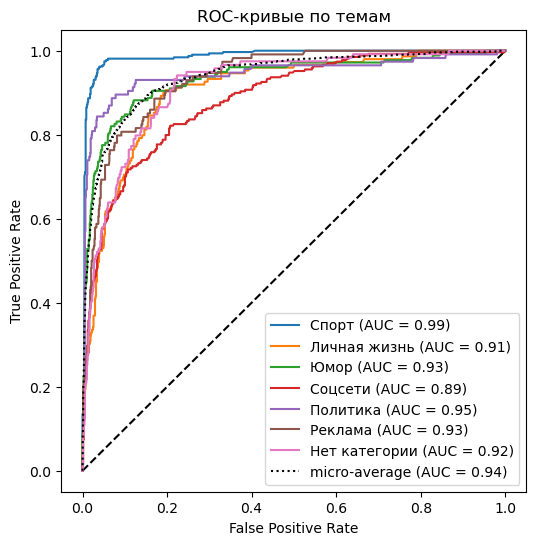

In [27]:
# Вычисляем точки для ROC-кривых
fpr = {}
tpr = {}
roc_auc = {}
for i, topic in enumerate(label_cols):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Микро-усредненная ROC (считаем как если все метки в один длинный список)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Строим график
plt.figure(figsize=(6, 6))
# Диагональ случайного угадывания
plt.plot([0, 1], [0, 1], 'k--')
# Кривые по темам
for i, topic in enumerate(label_cols):
    plt.plot(fpr[i], tpr[i], label=f"{topic} (AUC = {roc_auc[i]:.2f})")
# Микро усредненная кривая
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC = {roc_auc['micro']:.2f})", color='black', linestyle=':')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые по темам")
plt.legend(loc="lower right")
plt.show()


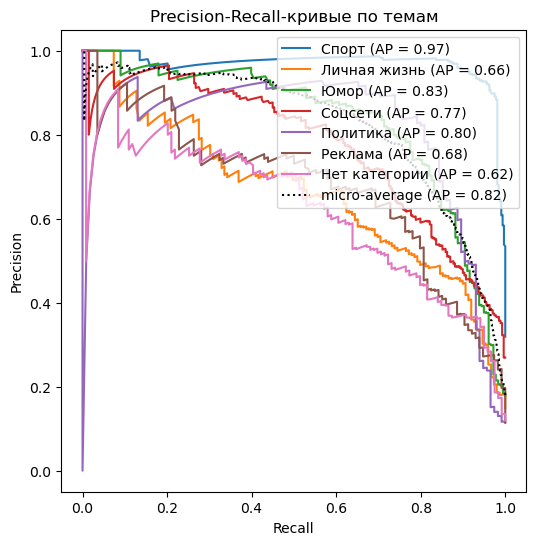

In [28]:
plt.figure(figsize=(6, 6))
for i, topic in enumerate(label_cols):
    precision, recall, _ = precision_recall_curve(y_true[:, i], probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{topic} (AP = {pr_auc:.2f})")
# микро-усредненная PR
precision_micro, recall_micro, _ = precision_recall_curve(y_true.ravel(), probs.ravel())
ap_micro = auc(recall_micro, precision_micro)
plt.plot(recall_micro, precision_micro, label=f"micro-average (AP = {ap_micro:.2f})", color='black', linestyle=':')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-кривые по темам")
plt.legend(loc="upper right")
plt.show()


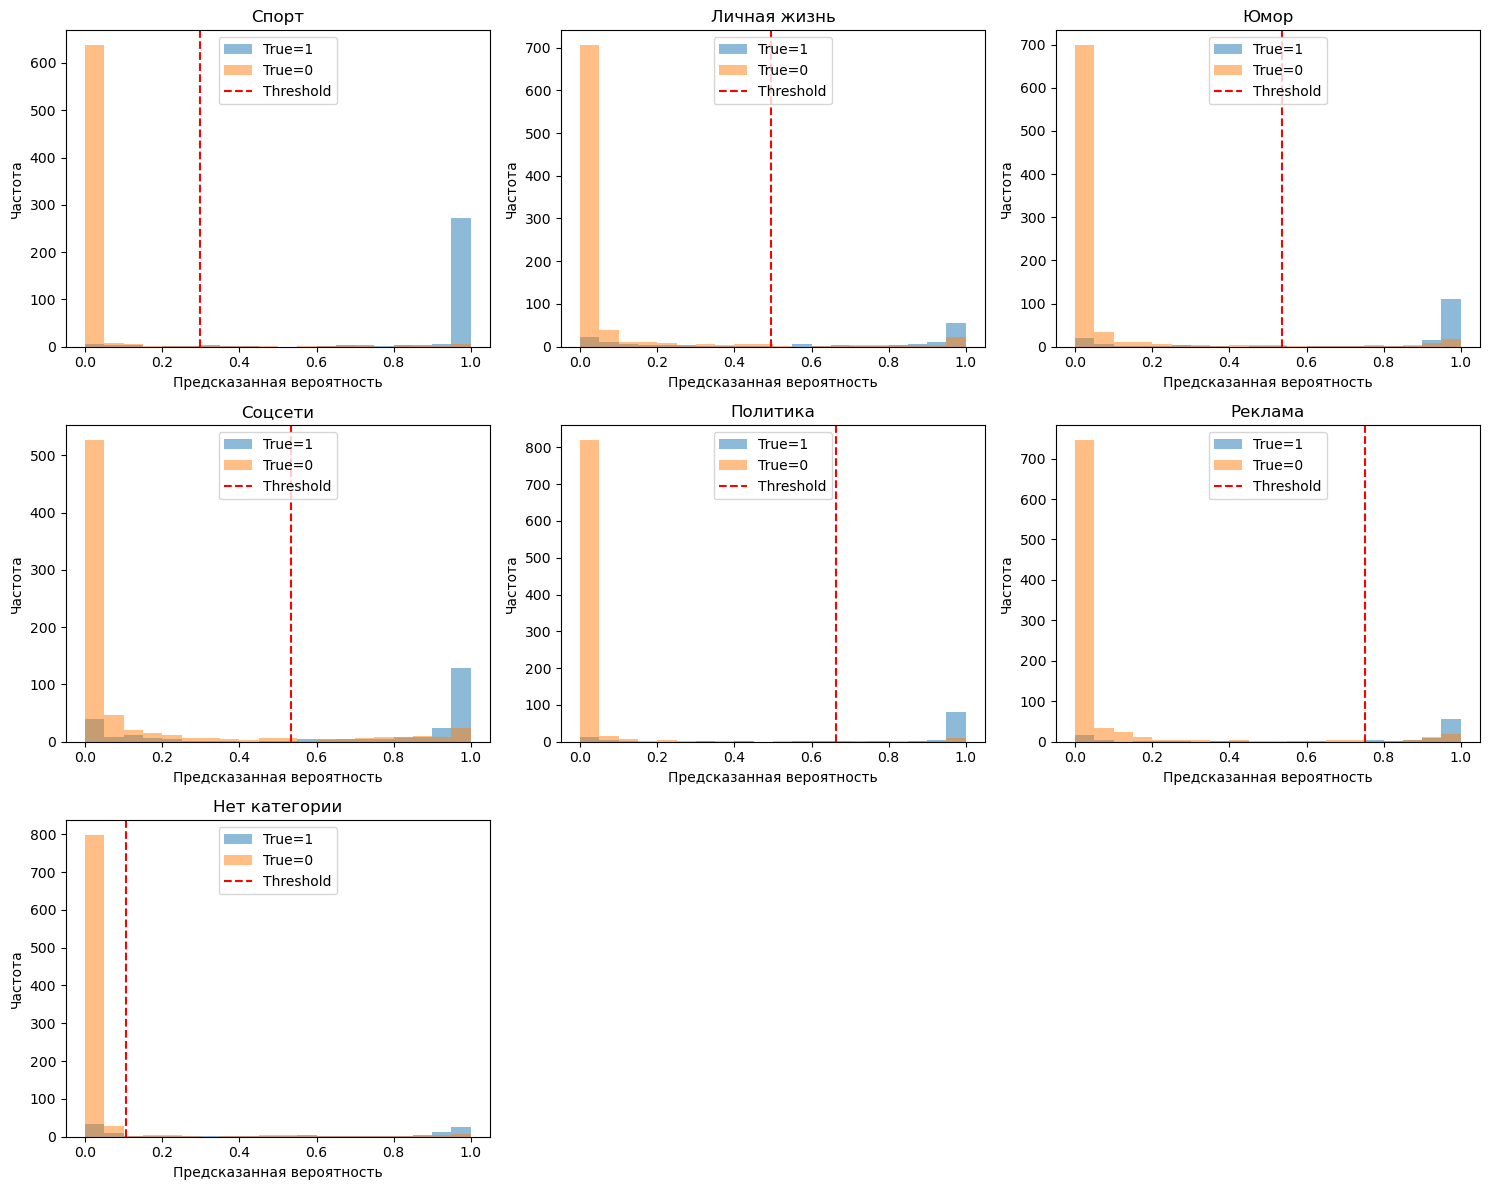

In [29]:
n_labels = len(label_cols)
n_cols = 3
n_rows = math.ceil(n_labels / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(label_cols):
    ax = axes[i]
    pos_probs = probs[y_true[:, i] == 1, i]
    neg_probs = probs[y_true[:, i] == 0, i]
    ax.hist(pos_probs, bins=20, range=(0,1), alpha=0.5, label="True=1")
    ax.hist(neg_probs, bins=20, range=(0,1), alpha=0.5, label="True=0")
    ax.axvline(best_thresholds.get(topic, 0.5), color='red', linestyle='--', label='Threshold')
    ax.set_title(topic)
    ax.set_xlabel("Предсказанная вероятность")
    ax.set_ylabel("Частота")
    ax.legend(loc="upper center")

# Отключим пустые графики если их больше, чем нужно
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

